In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Reshape, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/PSM1/fastaFile")

In [ ]:
input_list = ["atv.fasta", "ddi.fasta", "etr.fasta", "rpv.fasta", "drv.fasta", "tpv.fasta",
              "lpv.fasta", "sqv.fasta", "nfv.fasta", "fpv.fasta", "idv.fasta", "dft.fasta",
              "abc.fasta", "azt.fasta", "efv.fasta", "nvp.fasta", "tdf.fasta", "ttc.fasta"]

In [ ]:
def convert_to_int(sequence):
    char_to_int = {
        'A': 1, 'a': 1, 'B': 2, 'b': 2, 'C': 3, 'c': 3, 'D': 4, 'd': 4,
        'E': 5, 'e': 5, 'F': 6, 'f': 6, 'G': 7, 'g': 7, 'H': 8, 'h': 8,
        'I': 9, 'i': 9, 'J': 10, 'j': 10, 'K': 11, 'k': 11, 'L': 12, 'l': 12,
        'M': 13, 'm': 13, 'N': 14, 'n': 14, 'O': 15, 'o': 15, 'P': 16, 'p': 16,
        'Q': 17, 'q': 17, 'R': 18, 'r': 18, 'S': 19, 's': 19, 'T': 20, 't': 20,
        'U': 21, 'u': 21, 'V': 22, 'v': 22, 'W': 23, 'w': 23, 'X': 24, 'x': 24,
        'Y': 25, 'y': 25, 'Z': 26, 'z': 26, '.': 27, '#': 28, '~': 29, '*': 30
    }
    return [char_to_int.get(char, 0) for char in sequence]

In [ ]:
# Initialize arrays to store labels and sequences
data_labels = []
data_seqs = []

# Process each input file
for infile in input_list:
    index = input_list.index(infile) + 1
    genecode = "PR" if index in [1, 5, 6, 7, 8, 9, 10, 11] else "RT"

    if genecode == "RT":
        bp = 240
    elif genecode == "PR":
        bp = 99

    with open(infile, "r") as fasta_file:
        fasta_lines = fasta_file.readlines()

    fasta = [line.strip() for line in fasta_lines if line.strip()]

    # Use a set to track unique sequences
    unique_sequences = set()

    # Read fasta file and extract labels and sequences
    for i in range(0, len(fasta), 2):
        # Validate format
        if fasta[i].startswith('>') and len(fasta) > i + 1:
            seqID = fasta[i][1:]  # Remove '>' to get seqID
            seq = fasta[i + 1].strip()  # Strip newline and whitespace

            # Extract resistant class (0 or 1) from the last character of seqID
            try:
                resistant_class = int(seqID[-1])
            except ValueError:
                continue  # Skip if the resistant class is not an integer

            # Strip seqID to only keep the sequence label
            seq_label = seqID[:-1]

            # Check for duplicates
            if seq in unique_sequences:
                continue  # Skip duplicate sequences
            unique_sequences.add(seq)

            # Append to data_labels and data_seqs
            data_labels.append(resistant_class)
            data_seqs.append(seq)

# Convert lists to numpy arrays
data_labels = np.array(data_labels)
data_seqs = np.array(data_seqs)

# print("Data Labels (Resistant Class):", data_labels)
# print("\nData Sequences:")
# for label, seq in zip(data_labels, data_seqs):
#     print(f"Resistant Class: {label}, Sequence: {seq}")

print(data_seqs)

['PQITLWQRFLVTIKIGGQLKEALLDTGANDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQPLIEICGHKIIGTVLVGPTPVVIIGDNLLTQIGCTLN1'
 'PQITLWQRILVTIKIGGQMKEALLDTGADDTVLEIMNLPGRWKPKMIGGIGGFIKVRQYDVPLIIICGHVASGTVLVGPTPVVIIGRNMLTQIGCTLN1'
 'PQITLWQRPLVVIKIGGQRKEALLDTGANDTVLDISNLPGRWKPKMIGGIGGFIKKEQYDVPLIEICGHTAIGTVLVGPTPVVIIGDNMLTQIGCTLN1'
 ...
 'PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLEQKKSVTVLDVGDAYFSVPLDKDFRKYTAFTIPSINNKTPGIRYQYNVLPQGWKGSPAIFQCSMTKILEPFRKQNPDIVIYQYIDDLYVGSDLEIGQHRTKIEELRQHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWT'
 'PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKQKKSVTVLDVGDAYFSVPLDKDFRKYTAFTIPSINNKTPGIRYQYNVLPQGWKGSPAIFQCSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWT'
 'PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLEQKKSVTVLDVGDAYFSVPLDKDFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQCSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIG

In [ ]:
# Parameters
bp = 240  # Length of the sequences

# Initialize seqs_num array
seqs_num = np.zeros((len(data_seqs), bp), dtype=int)

# Convert sequences to integers
for i in range(len(data_seqs)):
    seq_int = convert_to_int(data_seqs[i])
    seqs_num[i, :len(seq_int)] = np.array(seq_int)

# Pad sequences to a maximum length of bp
data_f = pad_sequences(seqs_num, padding='post', maxlen=bp)

In [ ]:
# Number of folds for cross-validation
k = 5

# Create k-fold cross-validation
kf = KFold(n_splits=k)
validation_scores = []

# Iterate through the k folds
for train_index, val_index in kf.split(data_f):
        # Separate validation and training data
        validation_data_k = data_f[val_index]
        validation_labels_k = data_labels[val_index]
        training_data = data_f[train_index]
        training_labels = data_labels[train_index]

        # # Calculate class weights
        # zero = np.sum(training_labels == 0)
        # one = np.sum(training_labels == 1)
        # weight_real = 1
        # weight_fake = zero / one if one != 0 else 1  # Avoid division by zero

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
 # Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(training_labels), y=training_labels)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
# Performance measure function
def perf_measure(y_ref, y_pred):
    TP = FP = TN = FN = 0
    for i in range(len(y_pred)):
        if y_ref[i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_ref[i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_ref[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_ref[i] == 1 and y_pred[i] == 0:
            FN += 1
    return np.array([TP, FP, TN, FN])

# Function to calculate metrics
def calculate_metrics(TP, FP, TN, FN):
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    return accuracy, sensitivity, specificity, f1_score

In [ ]:
# Set random seed for numpy
np.random.seed(1234)

In [ ]:
# Ensure reproducibility for train_test_split
random_state = 1234

In [ ]:
# Split training data into further training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.2, random_state=random_state, stratify=training_labels)

In [ ]:
# # Reshape data for CNN
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
bp = X_train.shape[1]

In [ ]:
# Define the CNN model based on the provided R model structure
def get_model(bp):
    model = Sequential()
    model.add(Embedding(input_dim=bp, output_dim=128, input_length=bp))
    model.add(Conv1D(32, kernel_size=9, activation='relu', input_shape=(bp, 1)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(32, kernel_size=9, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Get the model
cnn_model = get_model(bp)

In [ ]:
# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/500
200/200 [==============================] - 32s 153ms/step - loss: 0.4511 - accuracy: 0.7795 - val_loss: 0.3699 - val_accuracy: 0.8283
Epoch 2/500
200/200 [==============================] - 30s 152ms/step - loss: 0.3827 - accuracy: 0.8196 - val_loss: 0.3589 - val_accuracy: 0.8340
Epoch 3/500
200/200 [==============================] - 28s 142ms/step - loss: 0.3667 - accuracy: 0.8270 - val_loss: 0.3425 - val_accuracy: 0.8440
Epoch 4/500
200/200 [==============================] - 31s 153ms/step - loss: 0.3548 - accuracy: 0.8323 - val_loss: 0.3618 - val_accuracy: 0.8346
Epoch 5/500
200/200 [==============================] - 29s 144ms/step - loss: 0.3507 - accuracy: 0.8334 - val_loss: 0.3344 - val_accuracy: 0.8452
Epoch 6/500
200/200 [==============================] - 30s 150ms/step - loss: 0.3452 - accuracy: 0.8378 - val_loss: 0.3350 - val_accuracy: 0.8393
Epoch 7/500
200/200 [==============================] - 31s 153ms/step - loss: 0.3399 - accuracy: 0.8377 - val_loss: 0.3361 -

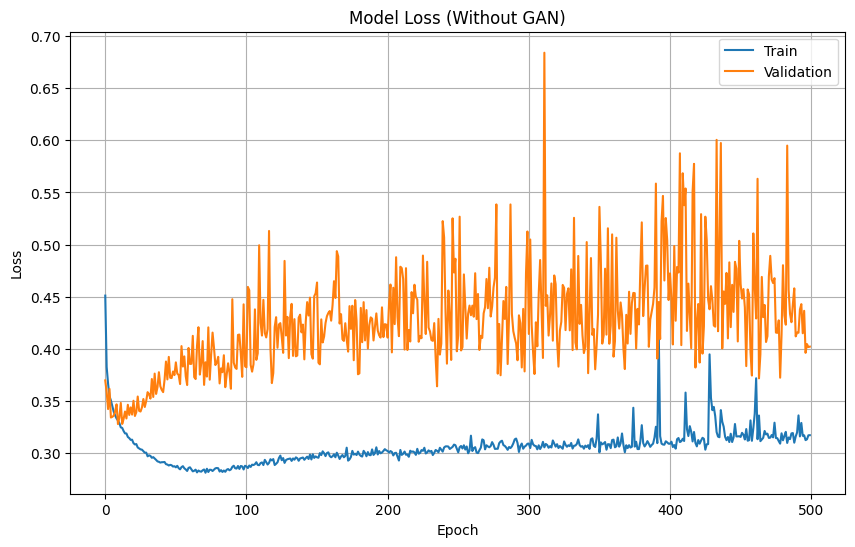

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Without GAN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the CNN model
y_pred = cnn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

100/100 [==============================] - 2s 17ms/step


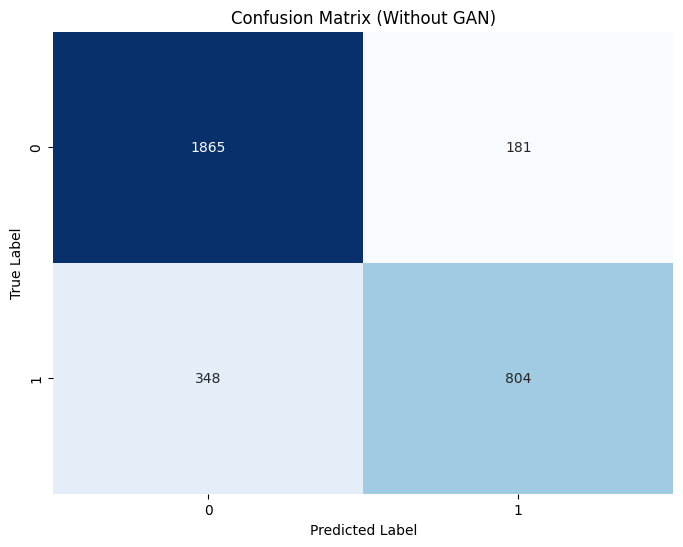

True Positives (TP): 804
False Positives (FP): 181
True Negatives (TN): 1865
False Negatives (FN): 348


In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Without GAN)')
plt.show()

# Extract TP, FP, TN, FN values from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

In [ ]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.83458411507192
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      2046
           1       0.82      0.70      0.75      1152

    accuracy                           0.83      3198
   macro avg       0.83      0.80      0.81      3198
weighted avg       0.83      0.83      0.83      3198



In [ ]:
# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')

AUC: 0.8047256842619744


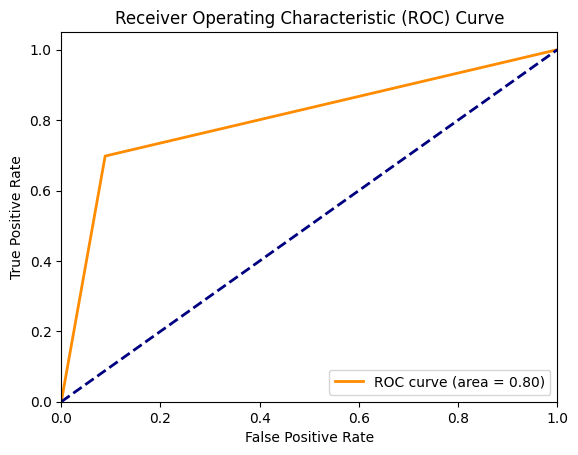

In [ ]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()